In [1]:
from tqdm import tqdm
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
from sympy import *
from IPython.display import display, Math
import numpy as np
init_printing(use_unicode=True)


In [2]:
from sympy import solve

x, y, sigma, mu, delta, alpha, beta, ro, eta, b, lambd = symbols(
    'x y σ μ δ α β ρ η b λ')

sigma_c = 0.1181
ro_c = 1.131
eta_c = 20.19
alpha_c = 1.636
beta_c = 0.002
delta_c = 0.3743
mu_c = 0.005
b_c = 0

dxdt = sigma + ro*x*y/(eta + y) - mu*x*y - delta*x
dydt = alpha*y*(1-beta*y)-x*y-(b*y)/(1+y)

concrete_params = {ro: ro_c, sigma: sigma_c, eta: eta_c, b: b_c,
                   alpha: alpha_c, beta: beta_c, mu: mu_c, delta: delta_c}
muless_params = dict(concrete_params)
del muless_params[mu]

bless_params = dict(concrete_params)
del bless_params[b]


In [3]:
display(Math('\dfrac{dx}{dt} = ' + latex(dxdt)))
display(Math('\dfrac{dy}{dt} = ' + latex(dydt)))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Точки равновесия

### 1

In [4]:
display(Math('x = ' + latex(sigma/delta)))
display(Math('y = 0'))  # Решение не зависит от μ


<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [5]:
# Остаьные равновесия аналитически не найти. Полином 5 степени.


In [6]:
def get_solutions(params):
    return solve([dxdt.subs(params), dydt.subs(params)], x, y)


In [7]:
def display_solutions(sols):
    for s in sols:
        display(s)


In [8]:
def display_sol_list(sol_list):
    for cur_mu, sols in sol_list:
        print(f"mu = {cur_mu}")
        display_solutions(sols)
        display("*"*20)


In [9]:
from typing import Tuple


def sol_is_almost_real(sol):
    x, y = sol
    return abs(im(x)) < 1e-10 and abs(im(y)) < 1e-10


def cast_to_real(sol):
    x, y = sol
    return float(re(x)), float(re(y))


In [10]:
dfdx = diff(dxdt, x)
dfdy = diff(dxdt, y)
dgdx = diff(dydt, x)
dgdy = diff(dydt, y)


In [11]:
display(Math('\dfrac{df}{dx} = ' + latex(dfdx)))
display(Math('\dfrac{df}{dy} = ' + latex(dfdy)))
display(Math('\dfrac{dg}{dx} = ' + latex(dgdx)))
display(Math('\dfrac{dg}{dy} = ' + latex(dfdy)))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [12]:
def get_eigen_values(x_eq, y_eq, params):
    a11 = dfdx.evalf(subs=params | {x: x_eq, y: y_eq})
    a12 = dfdy.evalf(subs=params | {x: x_eq, y: y_eq})
    a21 = dgdx.evalf(subs=params | {x: x_eq, y: y_eq})
    a22 = dgdy.evalf(subs=params | {x: x_eq, y: y_eq})
    jacob_matrix = Matrix([[a11, a12], [a21, a22]])
    j = jacob_matrix - np.eye(2) * lambd
    lam1, lam2 = solve(j.det(), lambd)
    return lam1, lam2


In [13]:
def get_line_mode(stable):
    return {} if stable else {"dash": "dot"}


In [14]:
# for s in get_solutions():
#     display(s)


#### Бифуркационная диаграмма

In [15]:
# mus = np.linspace(0.002, 0.022, 50)

mus = np.concatenate([
    np.linspace(0.0020, 0.0026, 50, endpoint=False),
    np.linspace(0.0026, 0.00265, 50, endpoint=False),
    np.linspace(0.00265, 0.0040, 50, endpoint=False),
    np.linspace(0.0040, 0.0130, 50, endpoint=False),
    np.linspace(0.0131, 0.0133, 50, endpoint=False),
    np.linspace(0.0130, 0.0135, 50, endpoint=False),
    np.linspace(0.0135, 0.0220, 50, endpoint=False)
])


In [16]:
xs = []
ys = []
mul = []
solutions_by_mu = {}
for cur_mu in tqdm(mus):
    solutions = get_solutions(muless_params | {mu: cur_mu})
    solutions = [cast_to_real(s) for s in solutions if sol_is_almost_real(s)]
    solutions_by_mu[cur_mu] = solutions


  1%|▎                                          | 3/350 [00:04<09:15,  1.60s/it]

KeyboardInterrupt



In [173]:
# y_im_parts = []
# x_im_parts = []
# mus_for_im=[]
# for cur_mu, sols in list(solutions_by_mu.items()):
#     for cur_x,cur_y in sols:
#         x_im_parts.append(float(cur_x))
#         y_im_parts.append(float(cur_y))
#         mus_for_im.append(cur_mu)

# fig = go.Figure()
# fig.add_trace(go.Scatter(x=mus_for_im, y=x_im_parts, mode='markers', name = "x_im_parts"))
# fig.add_trace(go.Scatter(x=mus_for_im, y=y_im_parts, mode='markers', name = "y_im_parts"))
# fig.update_layout(title="Imaginary parts of X and Y")
# fig.update_layout(xaxis={"title": "mu"})


На отрезке [0.005, 0.015] мнимая часть близка к нулю

In [174]:
mu_min = 0.002
mu_max = 0.017
filtered_solutions_by_mu = {
    mu: solutions_by_mu[mu] for mu in solutions_by_mu if mu_min < mu < mu_max}
# filtered_solutions_by_mu


In [178]:
# display_sol_list(list(filtered_solutions_by_mu.items())[:2])


In [191]:
xs = []
ys = []
mus_bif = []
df = pd.DataFrame(columns=['mu', 'x', 'y', 'stable'])
for cur_mu, sols in tqdm(list(filtered_solutions_by_mu.items())):
    for cur_x, cur_y in sols:
        lam1, lam2 = get_eigen_values(float(cur_x), float(
            cur_y), muless_params | {mu: cur_mu})
        stable = re(lam1) < 0 and re(lam2) < 0
        df.loc[len(df)] = [cur_mu, float(cur_x), float(cur_y), stable]


df.stable = df.stable.astype(bool)
df = df[df.y != 0]


# fig.add_trace(go.Scatter(x=stables.mu, y=stables.y, mode='markers', name = "y"))


100%|█████████████████████████████████████████| 313/313 [01:51<00:00,  2.81it/s]


In [192]:
df.y = df.y.astype('float')
df.stable = df.stable.astype(bool)

df.sort_values('y', inplace=True)
stables = df[df.stable]
dormants = df[df.stable & (df.y < 200)]
actives = df[df.stable & (df.y > 200)]
unstables = df[~df.stable]


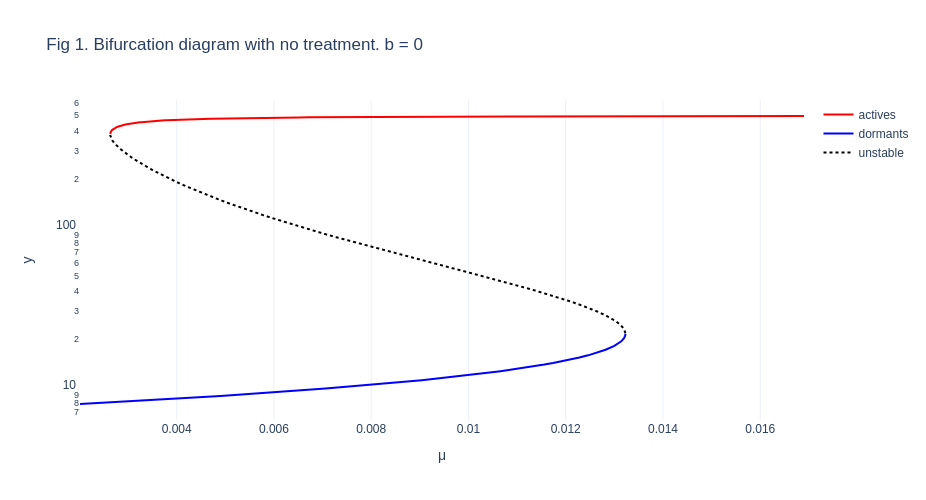

In [193]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=actives.mu, y=actives.y, mode='lines', name="actives",
                         line={"color": "red"} | get_line_mode(stable=True)))

fig.add_trace(go.Scatter(x=dormants.mu, y=dormants.y, mode='lines', name="dormants",
                         line={"color": "blue"} | get_line_mode(stable=True)))

fig.add_trace(go.Scatter(x=unstables.mu, y=unstables.y, mode='lines', name="unstable",
                         line={"color": "black"} | get_line_mode(stable=False)))
# fig.add_trace(go.Scatter(x=df.mu, y=df.y, mode='markers', name = "y"))
fig.update_layout(title="Fig 1. Bifurcation diagram with no treatment. b = 0")
fig.update_layout(xaxis={"title": "μ"}, yaxis={"title": "y"}, template="plotly_white", autosize=False,
                  width=600,
                  height=500)
fig.update_yaxes(type="log")
# fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)


## 𝜇 = 0.014. Monostable active. b is variable

In [42]:
mu_c = 0.014
bless_params[mu] = mu_c


In [43]:
def get_n_solutions_by_b(params, y_starts):
    res = set()
    for y_start in y_starts:
        try:
            res.add(ImmutableMatrix(
                nsolve([dxdt.subs(params), dydt.subs(params)], (x, y), (0, y_start))))
        # Could not find root within given tolerance. (1.56236416469305495856 > 2.16840434497100886801e-19)
        except ValueError:
            # Try another starting point or tweak arguments.
            pass
    return res


In [44]:
solutions_by_b = {}
bs_full_range = np.concatenate([
    np.linspace(0.0, 200, 500, endpoint=False),
    np.linspace(194, 195, 50, endpoint=False),
    np.linspace(10, 25, 100, endpoint=False),
])
bs_smalls = np.concatenate([
    np.linspace(0.0, 10, 100, endpoint=False),
    np.linspace(8.2, 8.4, 100, endpoint=False),
    np.linspace(8.334, 8.336, 10, endpoint=False)
])
for bs_set, y_starts in zip([bs_full_range, bs_smalls],
                            [np.linspace(0, 600, 6), np.linspace(0, 30, 6)]):
    for curb in tqdm(bs_set):
        solutions = get_n_solutions_by_b(bless_params | {b: curb}, y_starts)
        solutions = [cast_to_real(s)
                     for s in solutions if sol_is_almost_real(s)]
        solutions_by_b[curb] = solutions


 21%|████████▌                                | 136/650 [00:22<01:25,  5.99it/s]


KeyboardInterrupt: 

In [18]:
bif_solutions_by_b = dict(solutions_by_b)


In [19]:
df = pd.DataFrame({'b': pd.Series(dtype='float'),
                   'x': pd.Series(dtype='float'),
                   'y': pd.Series(dtype='float'),
                   'stable': pd.Series(dtype='bool')})
for curb, sols in tqdm(solutions_by_b.items()):
    for sol in sols:
        cur_x, cur_y = sol
        lam1, lam2 = get_eigen_values(
            float(cur_x), float(cur_y), bless_params | {b: curb})
        stable = re(lam1) < 0 and re(lam2) < 0
        df.loc[len(df)] = [curb, float(cur_x), float(cur_y), stable]

df.stable = df.stable.astype(bool)
orig = df.copy()


 70%|████████████████████████████▋            | 576/824 [02:16<00:58,  4.21it/s]


KeyboardInterrupt: 

In [ ]:
df.b = df.b.astype(float)


In [ ]:
# df = df[(df.y>=0) & (df.y.abs()>1e-10)]
df = df[(df.y >= 0)]
df.sort_values('y', inplace=True)


In [ ]:
fig = go.Figure()
stables = df[df.stable & (df.y != 0)]
unstables = df[~df.stable & (df.y != 0)]
zero_tumor_stables = df[df.stable & (df.y == 0)]
zero_tumor_unstables = df[~df.stable & (df.y == 0)]

fig.add_trace(go.Scatter(x=stables.b, y=stables.y, mode='lines', name="stables",
              line={"color": "red"} | get_line_mode(stable=True)))
fig.add_trace(go.Scatter(x=unstables.b, y=unstables.y, mode='lines', name="unstables",
                         line={"color": "red"} | get_line_mode(stable=False)))
fig.add_trace(go.Scatter(x=zero_tumor_stables.b, y=zero_tumor_stables.y, mode='lines', name="zero_tumor_stables",
                         line={"color": "green"} | get_line_mode(stable=True)))
fig.add_trace(go.Scatter(x=zero_tumor_unstables.b, y=zero_tumor_unstables.y, mode='lines', name="zero_tumor_unstables",
                         line={"color": "green"} | get_line_mode(stable=False)))

fig.update_layout(title="Fig 2(c). Bifurcation diagram. 𝜇 = 0.014")
fig.update_layout(xaxis={"title": "b"}, yaxis={"title": "y"}, template="plotly_white", autosize=False,
                  width=700,
                  height=500)


In [ ]:
# fig = go.Figure()
# stables = df[df.stable & (df.y != 0)]
# unstables = df[~df.stable & (df.y != 0)]
# zero_tumor_stables = df[df.stable & (df.y == 0)]
# zero_tumor_unstables = df[~df.stable & (df.y == 0)]

# fig.add_trace(go.Scatter(x=stables.b, y=stables.y, mode='lines+markers', name="stables",
#               line={"color": "red"} | get_line_mode(stable=True)))
# fig.add_trace(go.Scatter(x=unstables.b, y=unstables.y, mode='lines+markers', name="unstables",
#                          line={"color": "red"} | get_line_mode(stable=False)))
# fig.add_trace(go.Scatter(x=zero_tumor_stables.b, y=zero_tumor_stables.y, mode='lines+markers', name="zero_tumor_stables",
#                          line={"color": "green"} | get_line_mode(stable=True)))
# fig.add_trace(go.Scatter(x=zero_tumor_unstables.b, y=zero_tumor_unstables.y, mode='lines+markers', name="zero_tumor_unstables",
#                          line={"color": "green"} | get_line_mode(stable=False)))

# fig.update_layout(title="Fig 2(c). Bifurcation diagram. 𝜇 = 0.014")
# fig.update_layout(xaxis={"title": "b"}, yaxis={"title": "y"}, template="plotly_white", autosize=False,
#                   width=700,
#                   height=500)


In [24]:
# Note: b в районе 10 - 20 - решения не находятся


In [25]:
dfsmall = df[df.b.isin(bs_smalls)]


In [26]:
b1 = 5.8
b2 = 8.3356


In [27]:
lower_flexure = dfsmall[(dfsmall.y > 5) & (dfsmall.y < 17)]
upper_flexure = dfsmall[(dfsmall.y > 17) & (dfsmall.y < 24)]
b2_exp = lower_flexure.b.max()
b1_exp = upper_flexure.b.min()
lower_flexure_y = dfsmall[(dfsmall.b == b2_exp) & (
    dfsmall.y < 10.5) & (dfsmall.y > 9)]
b1_exp, b2_exp


In [28]:
y_low_thrsh = lower_flexure_y.y.mean()
y_low_thrsh


In [29]:
pink = dfsmall[(dfsmall.b <= b2) & (dfsmall.y <= y_low_thrsh)
               & ~dfsmall.stable & (dfsmall.y > 0)]
blue = dfsmall[(dfsmall.b >= b1) & (dfsmall.b <= b2) & (
    y_low_thrsh < dfsmall.y) & (dfsmall.y < 19) & ~dfsmall.stable]
red = dfsmall[(dfsmall.b > b1) & (dfsmall.y > 18.8) & ~dfsmall.stable]

zero_tumor_stables = dfsmall[dfsmall.stable & (dfsmall.y == 0)]
zero_tumor_unstables = dfsmall[~dfsmall.stable & (dfsmall.y == 0)]


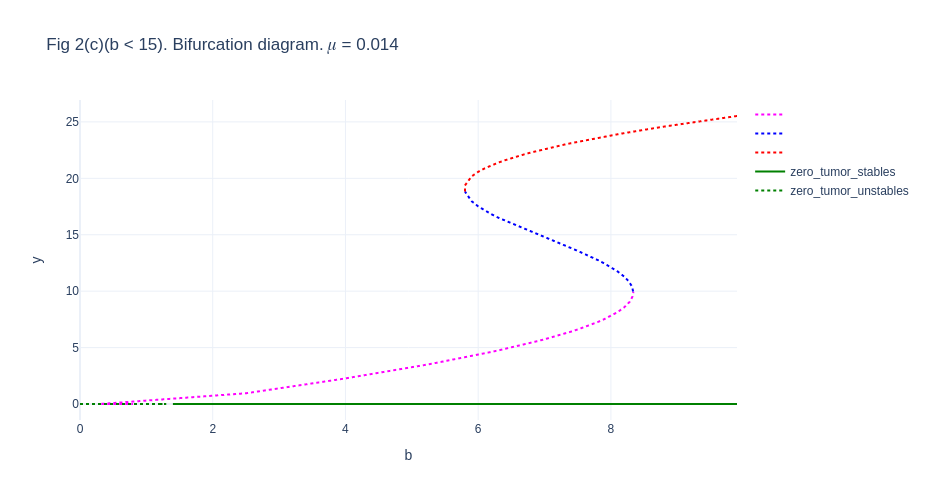

In [30]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=pink.b, y=pink.y, mode='lines', name="",
              line={"color": "magenta"} | get_line_mode(stable=False)))

fig.add_trace(go.Scatter(x=blue.b, y=blue.y, mode='lines', name="",
              line={"color": "blue"} | get_line_mode(stable=False)))

fig.add_trace(go.Scatter(x=red.b, y=red.y, mode='lines', name="",
              line={"color": "red"} | get_line_mode(stable=False)))

fig.add_trace(go.Scatter(x=zero_tumor_stables.b, y=zero_tumor_stables.y, mode='lines', name="zero_tumor_stables",
                         line={"color": "green"} | get_line_mode(stable=True)))
fig.add_trace(go.Scatter(x=zero_tumor_unstables.b, y=zero_tumor_unstables.y, mode='lines', name="zero_tumor_unstables",
                         line={"color": "green"} | get_line_mode(stable=False)))

fig.update_layout(title="Fig 2(c)(b < 15). Bifurcation diagram. 𝜇 = 0.014")
fig.update_layout(xaxis={"title": "b"}, yaxis={"title": "y"}, template="plotly_white", autosize=False,
                  width=700,
                  height=500)


In [31]:
df[df.b == 1]


,b,x,y,stable
1916,1.0,0.315522,0.0,False


In [22]:
# for bs_set, y_starts in zip([bs_full_range, bs_smalls],
#                             [np.linspace(0, 600, 6), np.linspace(0, 30, 6)]):


In [98]:
def get_n_solutions_by_bxy(params, starts):
    res = set()
    for x_start, y_start in (pbar := tqdm(starts)):
        pbar.set_description(f"Finding eq")
        try:
            res.add(ImmutableMatrix(
                nsolve([dxdt.subs(params), dydt.subs(params)], (x, y), (x_start, y_start))))
        # Could not find root within given tolerance. (1.56236416469305495856 > 2.16840434497100886801e-19)
        except ValueError:
            # Try another starting point or tweak arguments.
            pass
    return res


In [14]:
def f(x_c, y_c, params, reverse=False):  # dx/dt
    return (-1 if reverse else 1) * dxdt.evalf(subs=(params | {x: x_c, y: y_c}))


def g(x_c, y_c, params, reverse=False):  # dy/dt
    return (-1 if reverse else 1) * dydt.evalf(subs=(params | {x: x_c, y: y_c}))


def get_next(x, y, h, params, reverse=False):
    k1 = h * f(x, y, params, reverse=reverse)
    l1 = h * g(x, y, params, reverse=reverse)
    k2 = h * f(x + k1 / 2, y + l1 / 2, params, reverse=reverse)
    l2 = h * g(x + k1 / 2, y + l1 / 2,  params, reverse=reverse)
    k3 = h * f(x + k2 / 2, y + l2 / 2,  params, reverse=reverse)
    l3 = h * g(x + k2 / 2, y + l2 / 2,  params, reverse=reverse)
    k4 = h * f(x + k3, y + l3, params, reverse=reverse)
    l4 = h * g(x + k3, y + l3,  params, reverse=reverse)
    return (x + (k1 + 2 * k2 + 2 * k3 + k4) / 6,
            y + (l1 + 2 * l2 + 2 * l3 + l4) / 6)


In [99]:
from functools import lru_cache
import json
# @lru_cache
# def _get_path(start_no, num_steps, x_c, y_c, params):
#     paths = pd.DataFrame(columns=['no', 'step', 'x', 'y'])
#     for step in range(num_steps):
#         paths.loc[len(paths)] = [start_no, step, x_c, y_c]
#         x_c, y_c = get_next(x_c, y_c, H, dict(params))
#     return paths

# def get_paths(params, starts, num_steps):
#     paths = [] #pd.DataFrame(columns=['no', 'step', 'x', 'y'])
#     for start_no, (x_c, y_c) in tqdm(list(enumerate(starts))):
#         path = _get_path(start_no, num_steps, x_c, y_c, tuple(params.items()))
#         paths.append(path)
#     paths = pd.concat(paths)
#     paths["ysqrt4"] = np.power(paths.y, 1/4)
#     return paths.astype(float)


def _get_path(start_no, num_steps, x_c, y_c, params, reverse):
    paths = pd.DataFrame(columns=['no', 'step', 'x', 'y'])
    for step in range(num_steps):
        paths.loc[len(paths)] = [start_no, step, x_c, y_c]
        x_c, y_c = get_next(x_c, y_c, H, params, reverse)
    return paths


def get_paths(params, starts, num_steps, reverse=False):
    paths = []  # pd.DataFrame(columns=['no', 'step', 'x', 'y'])
    for start_no, (x_c, y_c) in (pbar := tqdm(list(enumerate(starts)))):
        pbar.set_description(f"Finding paths")
        path = _get_path(start_no, num_steps, x_c, y_c, params, reverse)
        paths.append(path)
    paths = pd.concat(paths)
    paths["ysqrt4"] = np.power(paths.y, 1/4)
    return paths.astype(float)


In [21]:
def union_same_solutions(solutions):
    return list(set((round(x,5), round(y,5) )for x,y in solutions))  


In [45]:
mu_c = 0.014
bless_params[mu] = mu_c

In [46]:
from itertools import product


### b = 1

In [47]:

b_c = 1
bs_set = [b_c]
solutions_by_b = {}
starts = list(product(np.linspace(0, 1, 10), np.linspace(256, 1400, 10)))
solutions = get_n_solutions_by_bxy(bless_params | {b: b_c}, starts)
solutions = [cast_to_real(s) for s in solutions if sol_is_almost_real(s)]


100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 38.99it/s]


In [50]:
united_solutions = sorted(union_same_solutions(solutions))
print(united_solutions)
eq_at, eq_zt = united_solutions


[(0.01906, 493.5581), (0.31552, 0.0)]


### Фазовые портреты. b = 1, 𝜇 = 0.014

In [51]:
H = 0.01 * 5


In [52]:
y_starts = np.concatenate([
    np.linspace(0.1, 1400, 6),
    [0.7**4, 3.4**4]
])
starts = list(product([4], y_starts))
paths = get_paths(bless_params | {b: b_c}, starts, num_steps=1000)


100%|█████████████████████████████████████████████| 8/8 [01:49<00:00, 13.64s/it]


In [61]:
zt_paths = get_paths(bless_params | {b: b_c},
                     starts=[(4, 0), (0.00001, 0)], num_steps=1000)


100%|█████████████████████████████████████████████| 2/2 [00:13<00:00,  6.96s/it]


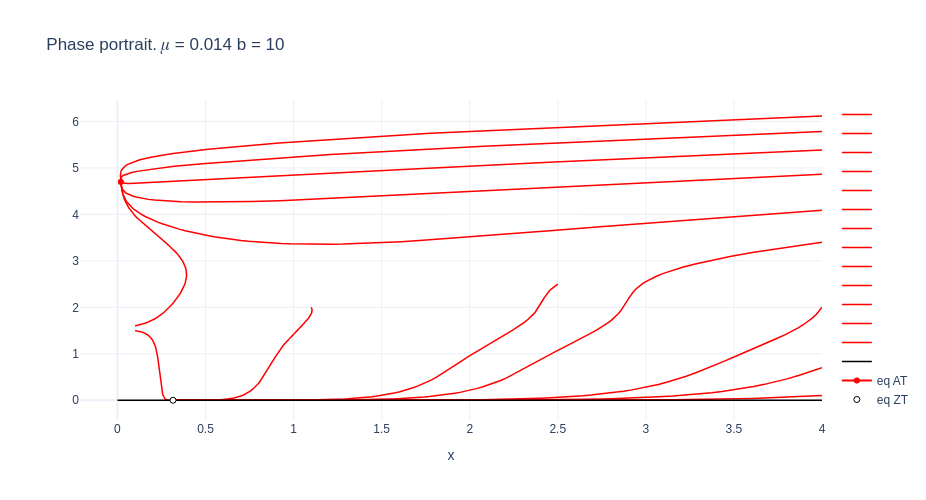

In [62]:
fig = go.Figure()
for path_no, path in paths.groupby("no"):
    fig.add_trace(go.Scatter(x=path.x, y=path.ysqrt4, mode='lines', name="",
                             line=dict(
                                 color='red',
                                 width=1.5)))
fig.add_trace(go.Scatter(x=zt_paths.x, y=zt_paths.ysqrt4, mode='lines', name="",
                         line=dict(
                             color='black',
                             width=1.5)))

fig.add_trace(go.Scatter(x=[eq_at[0]], y=[
              eq_at[1]**(1/4)], name='eq AT', line=dict(color='red')))
fig.add_trace(go.Scatter(x=[eq_zt[0]], y=[eq_zt[1]**(1/4)], name='eq ZT',
                         marker=dict(color='white',
                                     line=dict(color='black', width=1))))

fig.update_layout(title=f"Phase portrait. 𝜇 = 0.014 b = {b_c}")
fig.update_layout(xaxis={"title": "x"}, yaxis={
                  "title": r'$y^{1/4}$'}, template="plotly_white",
                  width=600,
                  height=500)
# TODO нарисовать равновесия


In [55]:
# NOTE Странно, равновесие ZT не как в статье. Да и прямая == 0 , показывает, что равновесие где-то в нуле.
# TODO нарисовать eq_undefined


### b = 10

In [56]:

b_c = 10
bs_set = [b_c]
solutions_by_b = {}
starts = (list(product(np.linspace(0, 1, 10), np.linspace(256, 1400, 10))) +
          list(product(np.linspace(0, 1, 10), np.linspace(0, 0.1**4, 10))))

solutions = get_n_solutions_by_bxy(bless_params | {b: b_c}, starts)
solutions = [cast_to_real(s) for s in solutions if sol_is_almost_real(s)]


100%|█████████████████████████████████████████| 200/200 [00:05<00:00, 36.17it/s]


In [57]:
united_solutions = sorted(union_same_solutions(solutions))
print(united_solutions)
eq_at, eq_zt, eq_sep = united_solutions

[(0.0193, 487.84856), (0.31552, -0.0), (1.17633, 25.60311)]


In [58]:
y_paths_starts = np.concatenate([
    np.linspace(0.1**4, 1400, 6),
    [0.7**4, 3.4**4, 2**4]
])
starts = list(product([4], y_paths_starts)) + [(1.1, 2**4),
                                               (0.1, 1.6**4),
                                               (0.1, 1.5**4),
                                               (2.5, 2.5**4)]
paths = get_paths(bless_params | {b: b_c}, starts, num_steps=1000)


100%|███████████████████████████████████████████| 13/13 [02:53<00:00, 13.35s/it]


In [59]:
# separatrix_starts = [(4, 2.9**4)]
# separatrix_starts = [(2, 2.5**4)]
separatrix_starts = [(1.2, 2.3**4), (1.15, 2.2**4)]
separatrix_paths = get_paths(bless_params | {b: b_c}, separatrix_starts, num_steps=1000, reverse=True)
separatrix_paths = separatrix_paths[(separatrix_paths.x<4) & (separatrix_paths.x>0)]
# separatrix_starts = []
# separatrix_path2 = get_paths(bless_params | {b: b_c}, separatrix_starts, num_steps=168, reverse=True)
# separatrix_path = pd.concat([separatrix_path1, separatrix_path2])

100%|█████████████████████████████████████████████| 2/2 [00:18<00:00,  9.11s/it]


In [64]:
# fig = go.Figure()
# for path_no, path in paths.groupby("no"):
#     # зеленая, если у пришел в 0. (ZT)
#     traj_color = 'green' if abs(path.y.iloc[-1] - 0) < 1e-6 else 'red'
#     fig.add_trace(go.Scatter(x=path.x, y=path.ysqrt4, mode='lines', name="",
#                              line=dict(
#                                  color=traj_color,
#                                  width=1.5)))

# fig.add_trace(go.Scatter(x=[eq_at[0]], y=[
#               eq_at[1]**(1/4)], name='eq AT', line=dict(color='red')))

# fig.add_trace(go.Scatter(x=[eq_sep[0]], y=[
#               eq_sep[1]**(1/4)], name='eq sep', 
#                         marker=dict(color='white',
#                                      line=dict(color='black', width=1))))

# fig.add_trace(go.Scatter(x=[eq_zt[0]], y=[eq_zt[1]**(1/4)], name='eq ZT',
#                          line=dict(color='green'))
#              )

# for path_no, path in separatrix_paths.groupby("no"):
#     fig.add_trace(go.Scatter(x=path.x, y=path.ysqrt4, mode='lines', name="",
#                              line=dict(
#                                  color='orange',
#                                  width=1.5)))



# fig.update_layout(title=f"Phase portrait. 𝜇 = 0.014 b = {b_c}")
# fig.update_layout(xaxis={"title": "x"}, yaxis={
#                   "title": r'$y^{1/4}$'}, template="plotly_white",
#                   width=600,
#                   height=500)
# # TODO нарисовать равновесия


In [67]:
def get_eqs(params):
    starts = (list(product(np.linspace(0, 1, 10), np.linspace(256, 1400, 10))) +
          list(product(np.linspace(0, 1, 10), np.linspace(0, 0.1**4, 10))))

    solutions = get_n_solutions_by_bxy(params, starts)
    solutions = [cast_to_real(s) for s in solutions if sol_is_almost_real(s)]
    return solutions

In [93]:
def get_fig_phase_portrait(paths, params):
    fig = go.Figure()
    for path_no, path in paths.groupby("no"):
        # зеленая, если у пришел в 0. (ZT)
        traj_color = 'green' if abs(path.y.iloc[-1] - 0) < 1e-6 else 'red'
        fig.add_trace(go.Scatter(x=path.x, y=path.ysqrt4, mode='lines', name="",
                                 line=dict(
                                     color=traj_color,
                                     width=1.5)))
    # fig.add_trace(go.Scatter(x=[eq_at[0]], y=[
    #               eq_at[1]**(1/4)], name='eq AT', line=dict(color='red')))

    # fig.add_trace(go.Scatter(x=[eq_sep[0]], y=[
    #               eq_sep[1]**(1/4)], name='eq sep', 
    #                         marker=dict(color='white',
    #                                      line=dict(color='black', width=1))))

    # fig.add_trace(go.Scatter(x=[eq_zt[0]], y=[eq_zt[1]**(1/4)], name='eq ZT',
    #                          line=dict(color='green'))
    #              )

    # for path_no, path in separatrix_paths.groupby("no"):
    #     fig.add_trace(go.Scatter(x=path.x, y=path.ysqrt4, mode='lines', name="",
    #                              line=dict(
    #                                  color='orange',
    #                                  width=1.5)))
    fig.update_layout(title=f"Phase portrait. 𝜇 = {params[mu]} b = {params[b]}")
    fig.update_layout(xaxis={"title": "x"}, yaxis={
                      "title": r'$y^{1/4}$'}, template="plotly_white",
                      width=600,
                      height=500)
    return fig
    # # TODO нарисовать равновесия


In [107]:
def compute_phase_portrait(b_const, paths_starts):
    params = bless_params | {b: b_const}
    eqs = get_eqs(params)
    united_solutions = sorted(union_same_solutions(solutions))
    paths = get_paths(params, paths_starts, num_steps=100)
    return eqs, get_fig_phase_portrait(paths, params)
    
    

Finding paths: 100%|██████████████████████████████| 6/6 [00:07<00:00,  1.32s/it]


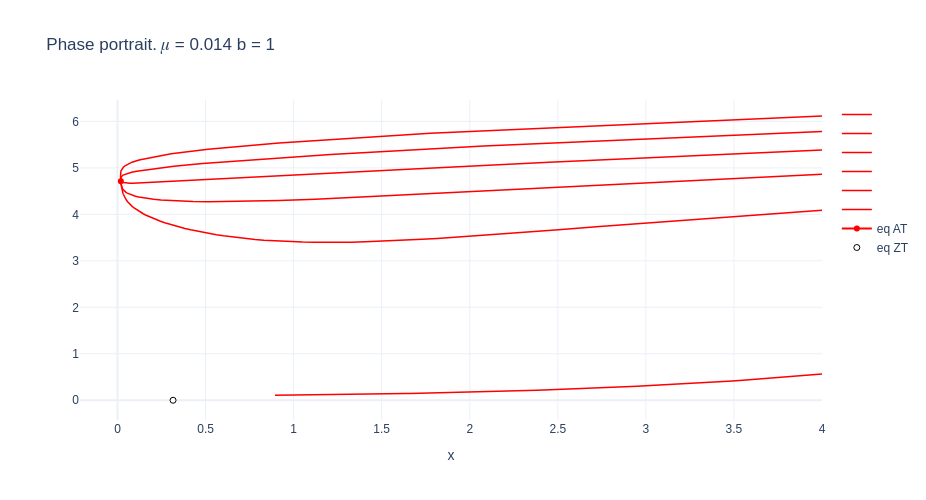

In [113]:
b_const = 1

y_starts = np.concatenate([
    np.linspace(0.1, 1400, 6),
    [3.4**4]
])
starts = list(product([4], y_starts))

eqs, fig = compute_phase_portrait(b_const, paths_starts=starts)
united_eqs = sorted(union_same_solutions(eqs))
# print(united_eqs)
eq_at, eq_zt = united_eqs

fig.add_trace(go.Scatter(x=[eq_at[0]], y=[
              eq_at[1]**(1/4)], name='eq AT', line=dict(color='red')))
fig.add_trace(go.Scatter(x=[eq_zt[0]], y=[eq_zt[1]**(1/4)], name='eq ZT',
                         marker=dict(color='white',
                                     line=dict(color='black', width=1))))
fig.show()

Finding paths: 100%|████████████████████████████| 13/13 [00:15<00:00,  1.21s/it]


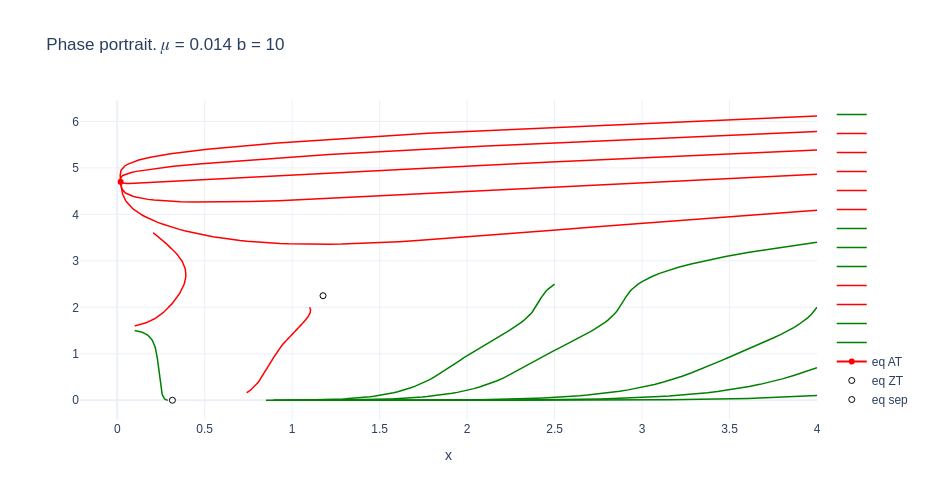

In [114]:
b_const = 10

y_paths_starts = np.concatenate([
    np.linspace(0.1**4, 1400, 6),
    [0.7**4, 3.4**4, 2**4]
])
starts = (list(product([4], y_paths_starts))
          + [(1.1, 2**4),
                                               (0.1, 1.6**4),
                                               (0.1, 1.5**4),
                                               (2.5, 2.5**4)]
         )
eqs, fig = compute_phase_portrait(b_const, paths_starts=starts)
united_eqs = sorted(union_same_solutions(eqs))
# print(united_eqs)
eq_at, eq_zt, eq_sep = united_eqs

fig.add_trace(go.Scatter(x=[eq_at[0]], y=[
              eq_at[1]**(1/4)], name='eq AT', line=dict(color='red')))
fig.add_trace(go.Scatter(x=[eq_zt[0]], y=[eq_zt[1]**(1/4)], name='eq ZT',
                         marker=dict(color='white',
                                     line=dict(color='black', width=1))))
fig.add_trace(go.Scatter(x=[eq_sep[0]], y=[
              eq_sep[1]**(1/4)], name='eq sep', 
                        marker=dict(color='white',
                                     line=dict(color='black', width=1))))

fig.show()